In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import allantools as at
from scipy.stats import norm
from scipy.interpolate import UnivariateSpline

# Section 1 - Define functions

In [4]:
save_dir = '/eos/user/e/elsweene/SWAN_projects/Filtered_data_sets/'

In [5]:
## Load in CSF data

Truncated_Time_data = pd.read_csv(save_dir +'Complete_CSF_Data_filtered.csv')
filter2 = pd.read_csv(save_dir +"CSF_data_frame_filter2.csv",index_col=0)
CSF_frame = pd.read_csv(save_dir +"CSF_data_frame_unfiltered.csv",index_col=0)

In [6]:
## Get rolling mean and fit line for linear drift

rolling_mean = np.array(Truncated_Time_data['f0'].rolling(window=24).mean().dropna())
shifted = np.array(Truncated_Time_data['f0'][:875]-rolling_mean[:875])
m_rm, b_rm = np.polyfit(Truncated_Time_data['TimeStamp'][:875],-1*rolling_mean[:875], 1)

In [7]:
## Function of fitted linear drift line 

def mean_line(x,m,b):
    
    line = m*x+b
    return line

In [8]:
## Define function to vary linear drift

def Vary_Linear_drift(A):
    
    linear_drift_array = -1*Truncated_Time_data['f0'][:875]
    fitted_lin_drift = mean_line(Truncated_Time_data['TimeStamp'][:875],(A-1)*m_rm,(((1-A)*m_rm*Truncated_Time_data['TimeStamp'][0])))
    
    new_linear_drift = linear_drift_array+fitted_lin_drift                            ## data with artificial drift
    
    m_LD, b_LD = np.polyfit(Truncated_Time_data['TimeStamp'][:875],new_linear_drift,1)    ## fit line to artificial drift
    
    return m_LD,b_LD

In [9]:
## Function for linear drift distribution

def linear_drift_dist(rm_range,linear_drift):

    list_differences = []

    for i in rm_range:

        x1 = linear_drift[i]
        x2 = linear_drift[i+1]

        diff = x1 - x2

        list_differences.append(diff)
    
    mu1, std1 = norm.fit(list_differences)
    
    return mu1,std1

In [10]:
## Function to add random walk drift to generated mean line data

def generate_random_walk(start_mean,start_sd,time_period,scalar,slope,constant):

    RW_Noise_data = []
    M= start_mean
    S = start_sd

    for i in time_period:
        #print(M)
        y_gen1 = mean_line(i,slope,constant)
        draw_noise = norm.rvs(loc=M,scale=(scalar*S),size=1)

        new_freq = y_gen1 + draw_noise

        RW_Noise_data.append(new_freq)

        M = draw_noise
        #print(M)
        
    Rand_walk_array = np.array(RW_Noise_data)
        
    return Rand_walk_array

In [11]:
## Define function to add white noise to generated data

def add_white_noise(index_array,RW_array,no_drift_array):    
    
    generated_freq = []
    mu, std = norm.fit(no_drift_array)

    for i in index_array:

        y_gen = RW_array[i]
        add_noise = norm.rvs(y_gen,scale= std,size=1)
        a = add_noise[0]

        generated_freq.append(a)
        
    return generated_freq

In [12]:
## Define function to fit line 

def fit_line(Array_of_interest1,Array_of_interest2,index,numberhrs):
    
    m,b = np.polyfit(Array_of_interest1[index:index+numberhrs],-1*Array_of_interest2[index:index +numberhrs], 1)
    
    return m,b

In [13]:
## Define function to steer CSF 

def CSF_Correction(loop_range,number_hours,data_set):
    
    ## Assign arrays for indexing

    F0_CSF_array_full = np.array(data_set)
    Time_CSF_array_full = np.array(extend_1yr)

    i = 0
    F0_CSF_array_full1= np.array(data_set)
    steps = []                                   # store steps to steer GPS data later

    for i in loop_range:
        
        #print(i)

        m,b = fit_line(Time_CSF_array_full,-1*F0_CSF_array_full1,i,number_hours)     ## fit to section of data 
        step_f = m*(Time_CSF_array_full[i+(number_hours-1)]) + b                ## calculate step using fit (removes outliers)

        steps.append(step_f)


        F0_CSF_array_full1[i:] -= step_f             # add step to all frequencies from this index on
        
        
    return F0_CSF_array_full1,steps

In [14]:


def Allan_Dev_Test(generated_data,step_sizes):

    AD_differences = []

    for i in step_sizes:

        jump_steer_array, steps = CSF_Correction(np.arange(0,(7656-i),i),i,generated_data) 

        (t5, ad5, ade5, adn5) = at.oadev(np.array(generated_data), rate=1/3600, data_type="freq",taus=np.logspace(0,6,100))
        (t6, ad6, ade6, adn6) = at.oadev(jump_steer_array, rate=1/3600, data_type="freq",taus=np.logspace(0,6,100))

        difference_array = ad5-ad6

        sum_difference_array = np.sum(difference_array)

        AD_differences.append(sum_difference_array)
        
    return AD_differences

In [15]:
## Define function to generate data 
## Some loop arrays - all to generate data up to 1 year

extend_1yr = np.arange(60006,60325,1/24)
index_array_yr = np.arange(0,7656,1)
AD_array_1week = np.arange(2,170,1)

def Generate_data(Random_Walk,Linear_Drift):
    
    mean,stan_dev = linear_drift_dist(np.arange(0,874,1),-1*rolling_mean)
    m_LD,b_LD = Vary_Linear_drift(Linear_Drift)
    
    generated_w_RW = generate_random_walk(mean,stan_dev,extend_1yr,Random_Walk,m_LD,b_LD)
    gen_data = add_white_noise(index_array_yr,generated_w_RW,shifted)
    
    AD_differences_list = Allan_Dev_Test(np.array(gen_data), np.arange(2,170,1))
    
    return AD_differences_list

In [16]:
## Define function to calculate implicit max of data set

def Implicit_Max(array,list_to_store):
    
    Max = np.max(array[12:])
    time_max = array.index(Max) + 2
    list_to_store.append(time_max)
    
    return list_to_store

In [46]:
## Define function to fit CUBIC to data and get max from that (eliminate outliers)

def Quadratic_Fit_Max(array,list_to_store):
    
    a,b,c,d,e,f = np.polyfit(np.arange(8,170,1),array[6:],5)
    quadratic_fit_array = a*np.arange(8,170,1)**5+b*np.arange(8,170,1)**4+c*np.arange(8,170,1)**3+d*np.arange(8,170,1)**2+e*np.arange(8,170,1)+f
    q_fit_list = quadratic_fit_array.tolist()
    fit_max = np.max(quadratic_fit_array[6:])
    
    fit_max_time = q_fit_list.index(fit_max) + 8               ## f index +2 = no hours
    list_to_store.append(fit_max_time)
    
    return list_to_store,quadratic_fit_array

In [18]:
# ## Define function to fit CUBIC to data and get max from that (eliminate outliers)

# def Quadratic_Fit_Max(array,list_to_store):
    
#     spl = UnivariateSpline(np.polyfit(np.arange(8,170,1),array[6:])
    
#     #a,b,c,d = np.polyfit(np.arange(8,170,1),array[6:],3)
#     #quadratic_fit_array = a*np.arange(8,170,1)**3+b*np.arange(8,170,1)**2+c*np.arange(8,170,1)+d
#     q_fit_list = quadratic_fit_array.tolist()
#     fit_max = np.max(quadratic_fit_array[6:])
    
#     fit_max = q_fit_list.index(fit_max) + 2               ## f index +2 = no hours
#     list_to_store.append(fit_max)
    
#     return list_to_store,quadratic_fit_array

# Section 2 - Run once for set LD and RW

In [19]:
## Do first step by hand

mean,stan_dev = linear_drift_dist(np.arange(0,874,1),-1*rolling_mean)

In [20]:
m_5x,b_5x = Vary_Linear_drift(5)

In [21]:
LD5_RW5 = generate_random_walk(mean,stan_dev,extend_1yr,5,m_5x,b_5x)

In [22]:
gen_data_5RW_LD = add_white_noise(index_array_yr,LD5_RW5,shifted)

In [23]:
test_5RW_5LD = Allan_Dev_Test(np.array(gen_data_5RW_LD), np.arange(2,170,1))

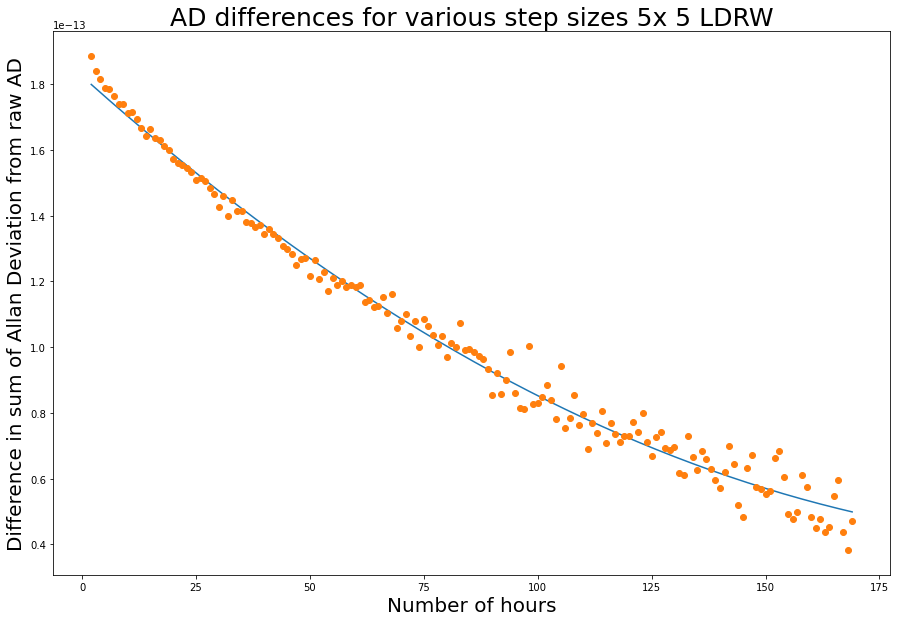

In [24]:
plt.figure(figsize=(15,10))

plt.xlabel('Number of hours',fontsize=20)
plt.ylabel('Difference in sum of Allan Deviation from raw AD',fontsize=20)
plt.title('AD differences for various step sizes 5x 5 LDRW',fontsize=25)


a,b,c = np.polyfit(np.arange(2,170,1),test_5RW_5LD,2)
quadratic_fit_array = a*np.arange(2,170,1)**2+b*np.arange(2,170,1)+c

plt.plot(np.arange(2,170,1),quadratic_fit_array)
plt.plot(np.arange(2,170,1),test_5RW_5LD,'o')

In [25]:
fit_max = np.max(quadratic_fit_array[12:])

In [26]:
q_fit_list = quadratic_fit_array.tolist()

In [27]:
q_fit_list.index(fit_max)           ## f index +2 = no hours

12

In [28]:
implicit_f_max = np.max(test_5RW_5LD[12:])

In [29]:
test_5RW_5LD.index(implicit_f_max)           ## f index +2 = no hours

13

In [30]:
np.arange(2,170,1)[12]      ## want to store this 

14

In [31]:
test_function = Generate_data(5,5)

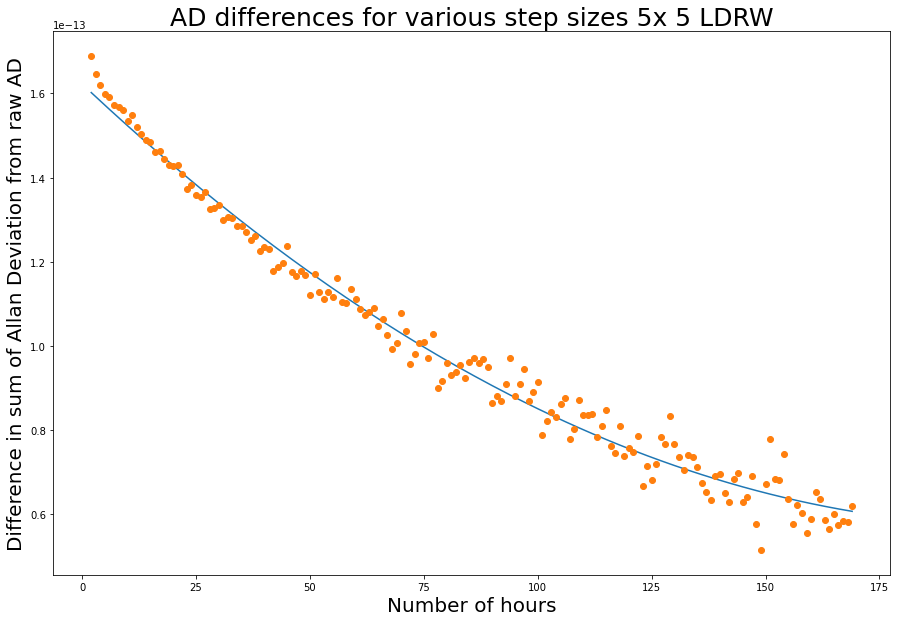

In [32]:
plt.figure(figsize=(15,10))

plt.xlabel('Number of hours',fontsize=20)
plt.ylabel('Difference in sum of Allan Deviation from raw AD',fontsize=20)
plt.title('AD differences for various step sizes 5x 5 LDRW',fontsize=25)


a,b,c = np.polyfit(np.arange(2,170,1),test_function,2)
quadratic_fit_array = a*np.arange(2,170,1)**2+b*np.arange(2,170,1)+c

plt.plot(np.arange(2,170,1),quadratic_fit_array)
plt.plot(np.arange(2,170,1),test_function,'o')

# Section 3 - Do this 10x and get average

In [171]:
# data_list = []
# added_list = []
# implicit_max_list = []
# quadratic_fit_max_list = []

# for i in np.arange(0,5,1):
    
#     data = Generate_data(5,5)
#     data_list.append(data)
    

# for n in np.arange(0,len(data_list[0]),1):
    
#     summed_up = data_list[i-5][n] + data_list[i-4][n] + data_list[i-3][n] + data_list[i-2][n] + data_list[i-1][n] +data_list[i][n]
#     added_list.append(summed_up)

# mean_array = np.array(added_list)/5
# mean_list = mean_array.tolist()

# implicit_f_max = np.max(mean_list[12:])
# implicit_max = mean_list.index(implicit_f_max) + 2      ## f index +2 = no hours
# implicit_max_list.append(implicit_max)

# a,b,c = np.polyfit(np.arange(2,170,1),mean_list,2)
# quadratic_fit_array = a*np.arange(2,170,1)**2+b*np.arange(2,170,1)+c
# q_fit_list = quadratic_fit_array.tolist()
# fit_max = np.max(quadratic_fit_array[12:])
# fit_max = q_fit_list.index(fit_max) + 2               ## f index +2 = no hours
# quadratic_fit_max_list.append(fit_max)

In [413]:
from datetime import datetime

In [415]:
s =datetime.now()
end = datetime.now()

print(end-s)

0:00:00.000148


In [416]:
## Loop to generate several sets of data for set LD and RW and get avg
s =datetime.now()
data_list = []
added_list = []
implicit_max_list = []
quadratic_fit_max_list = []

for i in np.arange(0,5,1):
    
    data = Generate_data(.1,1)
    data_list.append(data)
    
mean_array = np.mean(np.array(data_list),axis=0)
mean_list = mean_array.tolist()

Im_Max = Implicit_Max(mean_list,implicit_max_list)
Q_Fit_Max, Q_Fit = Quadratic_Fit_Max(mean_list,quadratic_fit_max_list)
end = datetime.now()

print(end-s)

0:00:36.739226


In [279]:
len(mean_list)

168

In [280]:
Q_Fit_Max

[56]

In [281]:
Im_Max

[55]

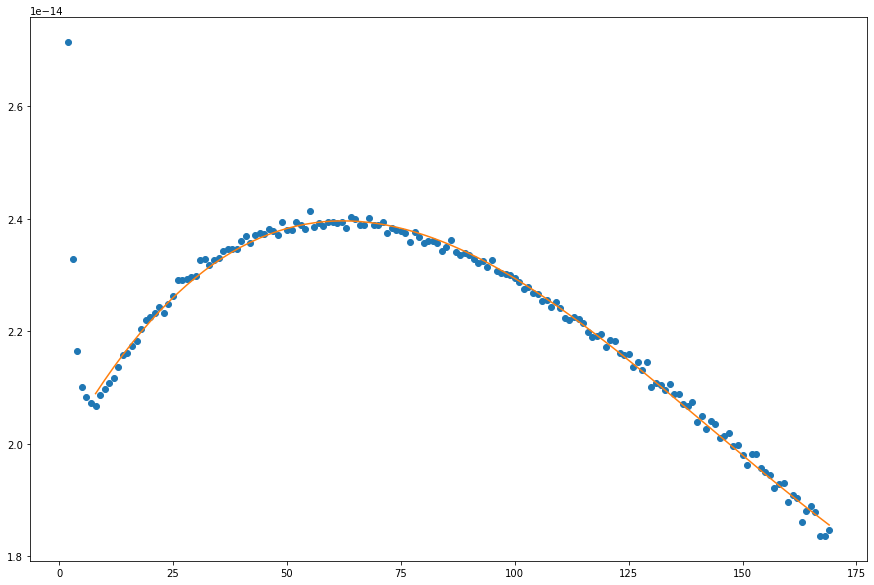

In [282]:
plt.figure(figsize=(15,10))

plt.plot(np.arange(2,170,1),mean_list,'o')
plt.plot(np.arange(8,170,1),Q_Fit)

## 3.1 Run set LD and RW 1000x 

In [33]:
save_dir1 = '/eos/user/e/elsweene/SWAN_projects/'

In [34]:
most_recent_data = pd.read_csv(save_dir1 +'recent_data_30_days_04_08.csv')

In [35]:
#plt.plot(most_recent_data['timestamp'],-1*most_recent_data['f0'],'x')

In [36]:
##

rolling_mean_updated = np.array(most_recent_data['f0'].rolling(window=24).mean().dropna())
shifted_updated = np.array(most_recent_data['f0'][:512]-rolling_mean_updated)
m_rm1, b_rm1 = np.polyfit(most_recent_data['timestamp'][:512],-1*rolling_mean_updated[:512], 1)

In [37]:
## Define function to vary linear drift for up to date data

def Vary_Linear_drift_updated(A):
    
    linear_drift_array = -1*most_recent_data['f0'][:512]
    fitted_lin_drift = mean_line(most_recent_data['timestamp'][:512],(A-1)*m_rm1,(((1-A)*m_rm1*most_recent_data['timestamp'][0])))
    
    new_linear_drift = linear_drift_array+fitted_lin_drift                            ## data with artificial drift
    
    m_LD1, b_LD1 = np.polyfit(most_recent_data['timestamp'][:512],new_linear_drift,1)    ## fit line to artificial drift
    
    return m_LD1,b_LD1

In [38]:
## Define function to generate data up to date
## Some loop arrays - all to generate data up to 1 year from MJD 60060

extend_1yr_up_to_date = np.arange(60160,60525,1/24)
index_array_yr_up_to_date = np.arange(0,8760,1)
AD_array_1week = np.arange(2,170,1)

def Generate_data_up_to_date(Random_Walk,Linear_Drift):
    
    mean1,stan_dev1 = linear_drift_dist(np.arange(0,511,1),-1*rolling_mean_updated)
    m_LD1,b_LD1 = Vary_Linear_drift_updated(Linear_Drift)
    #print(m_LD1,b_LD1)
    
    generated_w_RW = generate_random_walk(mean1,stan_dev1,extend_1yr_up_to_date,Random_Walk,m_LD1,b_LD1)
    gen_data = add_white_noise(index_array_yr_up_to_date,generated_w_RW,shifted_updated)
    
    AD_differences_list = Allan_Dev_Test(np.array(gen_data), np.arange(2,170,1))
    
    return AD_differences_list

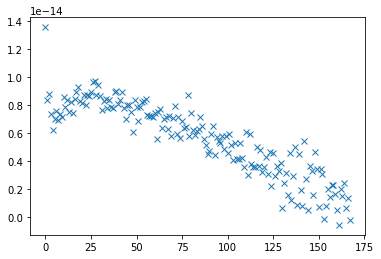

In [40]:
plt.plot(Generate_data_up_to_date(1,1),'x')

In [82]:
data_list_updated = []
added_list_updated = []
implicit_max_list_updated = []
quadratic_fit_max_list_updated = []

for i in np.arange(0,1000,1):
    
    data_updated = Generate_data_up_to_date(1,1)
    data_list_updated.append(data_updated)
    
mean_array_updated = np.mean(np.array(data_list_updated),axis=0)
mean_list_updated = mean_array_updated.tolist()

Im_Max_updated = Implicit_Max(mean_list_updated,implicit_max_list_updated)
Q_Fit_Max_updated, Q_Fit_updated = Quadratic_Fit_Max(mean_list_updated,quadratic_fit_max_list_updated)

In [47]:
Im_Max_updated = Implicit_Max(mean_list_updated,implicit_max_list_updated)
Q_Fit_Max_updated, Q_Fit_updated = Quadratic_Fit_Max(mean_list_updated,quadratic_fit_max_list_updated)

NameError: name 'mean_list_updated' is not defined

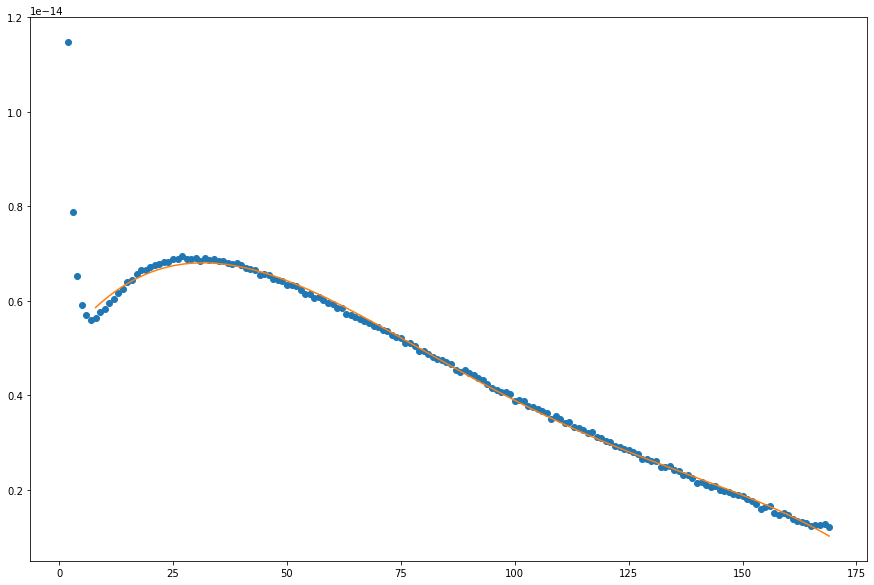

In [83]:
plt.figure(figsize=(15,10))

plt.plot(np.arange(2,170,1),mean_list_updated,'o')
plt.plot(np.arange(8,170,1),Q_Fit_updated)

In [84]:
Q_Fit_Max_updated

[32]

In [85]:
Im_Max_updated

[27]

# Section 4 - Extend loop to vary RW and LD

In [28]:
RW_range= np.arange(0.1,2.1,0.1)

In [29]:
LD_range = np.arange(-5,5.1,0.2)

In [30]:
print(len(LD_range)*len(RW_range))

1020


In [31]:
implicit_max_list = []
quadratic_fit_max_list = []
store_LD = []
store_RW = []

for s in RW_range:
    print(s)
    
    for n in LD_range:

        data_list = []
        added_list = []

        for i in np.arange(0,5,1):

            data = Generate_data(s,n)
            data_list.append(data)

        mean_array = np.mean(np.array(data_list),axis=0)
        mean_list = mean_array.tolist()

        Im_Max = Implicit_Max(mean_list,implicit_max_list)
        Q_Fit_Max, Q_Fit = Quadratic_Fit_Max(mean_list,quadratic_fit_max_list)

        #plt.plot(np.arange(2,170,1),mean_list,'o')
        #plt.plot(np.arange(8,170,1),Q_Fit)

        store_LD.append(n)
        store_RW.append(s)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
1.5000000000000002
1.6
1.7000000000000002
1.8000000000000003
1.9000000000000001
2.0


In [39]:
data = {'Fit_max': Q_Fit_Max,
        'IM_max': Im_Max,
       'Ld':store_LD,
       'RW':store_RW}
  
df_analysis = pd.DataFrame(data, columns=['Fit_max', 'IM_max','Ld','RW'])

In [89]:
#Q_Fit_Max

In [88]:
#Im_Max

In [86]:
#store_LD

In [87]:
#store_RW

In [36]:
save_dir = '/eos/user/e/elsweene/SWAN_projects/Filtered_data_sets/'

In [40]:
df_analysis.to_csv(save_dir+"Q_Fit_Max.csv", index=False)

# RW and LD analysis - up to date data (04.08)

In [101]:
RW_range = np.arange(0.1,2.1,0.1)
LD_range = np.arange(-5,5.2,0.2)

In [102]:
print(len(LD_range)*len(RW_range))

1020


In [103]:
implicit_max_list_updated = []
quadratic_fit_max_list_updated = []
store_LD_updated = []
store_RW_updated = []

for s in RW_range:
    print(s)
    
    for n in LD_range:

        data_list_updated = []
        added_list_updated = []

        for i in np.arange(0,5,1):

            data_updated = Generate_data_up_to_date(s,n)
            data_list_updated.append(data_updated)

        mean_array_updated = np.mean(np.array(data_list_updated),axis=0)
        mean_list_updated = mean_array_updated.tolist()

        Im_Max_updated = Implicit_Max(mean_list_updated,implicit_max_list_updated)
        Q_Fit_Max_updated, Q_Fit_updated = Quadratic_Fit_Max(mean_list_updated,quadratic_fit_max_list_updated)

        #plt.plot(np.arange(2,170,1),mean_list,'o')
        #plt.plot(np.arange(8,170,1),Q_Fit)

        store_LD_updated.append(n)
        store_RW_updated.append(s)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
1.5000000000000002
1.6
1.7000000000000002
1.8000000000000003
1.9000000000000001
2.0


In [104]:
data1 = {'Fit_max': Q_Fit_Max_updated,
        'IM_max': Im_Max_updated,
       'Ld':store_LD_updated,
       'RW':store_RW_updated}
  
df_analysis1 = pd.DataFrame(data1, columns=['Fit_max', 'IM_max','Ld','RW'])

In [106]:
df_analysis1

,Fit_max,IM_max,Ld,RW
0,87,92,-5.0,0.1
1,89,106,-4.8,0.1
2,128,92,-4.6,0.1
3,93,84,-4.4,0.1
4,98,98,-4.2,0.1
...,...,...,...,...
1015,14,18,4.2,2.0
1016,14,14,4.4,2.0
1017,14,15,4.6,2.0
1018,14,14,4.8,2.0


In [107]:
save_dir = '/eos/user/e/elsweene/SWAN_projects/Filtered_data_sets/'

In [108]:
df_analysis1.to_csv(save_dir+"recent_analysis.csv", index=False)

In [43]:
test_data = Generate_data_up_to_date(0.1,-5)

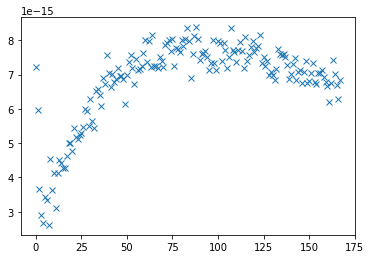

In [45]:
plt.plot(test_data,'x')